In [1]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [3]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'wall_expungements', 'walls', 'walls_sets']


In [4]:
def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

In [5]:
# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

In [6]:
# this feels so wrong but wcyd. Could reduce the lines of code but lets just keep it easy to read and understand
def map_vgrade(difficulty):
    if 10 <= difficulty < 12:
        return 0
    elif 12 <= difficulty < 14:
        return 1
    elif 14 <= difficulty < 16:
        return 2
    elif 16 <= difficulty < 18:
        return 3
    elif 18 <= difficulty < 20:
        return 4
    elif 20 <= difficulty < 22:
        return 5
    elif 22 <= difficulty < 23:
        return 6
    elif 23 <= difficulty < 24:
        return 7
    elif 24 <= difficulty < 26:
        return 8
    elif 26 <= difficulty < 28:
        return 9
    elif 28 <= difficulty < 29:
        return 10
    elif 29 <= difficulty < 30:
        return 11
    elif 30 <= difficulty < 31:
        return 12
    elif 31 <= difficulty < 32:
        return 13
    elif 32 <= difficulty < 33:
        return 14
    elif difficulty >= 33:
        return 15
    else:
        return None


### Create DF with necessary columns and data

In [7]:
# print(globals()['ascents'].head().to_string(index=False))
climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
# climb_cache_fields = globals()['climb_cache_fields']
merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner') #.drop(columns=['frames'])
# Drop rows with layout_id not equal to 1
merged_df = merged_df[merged_df['layout_id'] == 1]

# remove rows with more than 1 ascensionist
merged_df = merged_df[merged_df['ascensionist_count'] >= 2]
merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
filtered_df = merged_df.loc[:, filtered_columns]

# print(merged_df_filtered.head().to_string(index=False))
show(filtered_df)

# r12 - starthold  5
# r13 - hand hold  2
# r14 - finish hold 3
# r15 - foot hold   4
# p - hold position?

# p1454r15p1455r15p1457r15p1467r15p1469r15p1477r15p1485r15p1493r15p1511r15p1521r15p1532r15p1547r15p1549r15
# p1144r15 p1195r13 p1196r12 p1233r12 p1268r13 p1280r13 p1304r13 p1355r13 p1375r13 p1393r14 p1504r15 p1506r15 p1524r15 p1534r15 p1572r15 - EK | Crimp is not a crux

# p1085r15 p1124r12 p1176r12 p1196r13 p1244r13 p1283r13 p1332r13 p1383r14 p1385r14 p1504r15 p1514r15 - Pinch n' Gaston

# p1205r15 p1234r12 p1272r13 p1303r13 p1340r13 p1387r14 p1487r15 p1514r15 -sheep4wood

# p1165r12 p1271r13 p1286r13 p1333r14 p1469r15 p1476r15 - Fission

# p1146r12 p1163r12 p1227r13 p1249r13 p1265r13 p1269r14 p1457r15 p1467r15 p1484r15 p1496r15 p1503r15 p1506r15 p1516r15 - Plastic Age Mindset

# p1127r12 p1164r12 p1233r13 p1235r13 p1283r13 p1287r13 p1299r13 p1348r13 p1379r14 p1458r15 p1507r15 - anti-compressant

#layout_ids
# 1 - original board ( only meaningfulone)
# 2-8 ( other boards)


PandasGUI INFO — pandasgui.gui — Opening PandasGUI


### Some Graphs

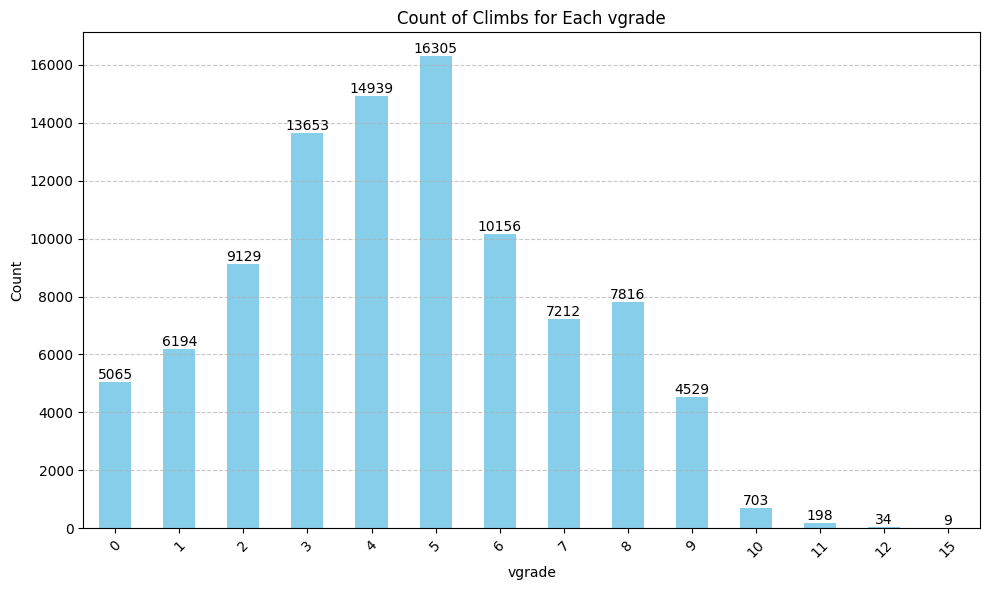

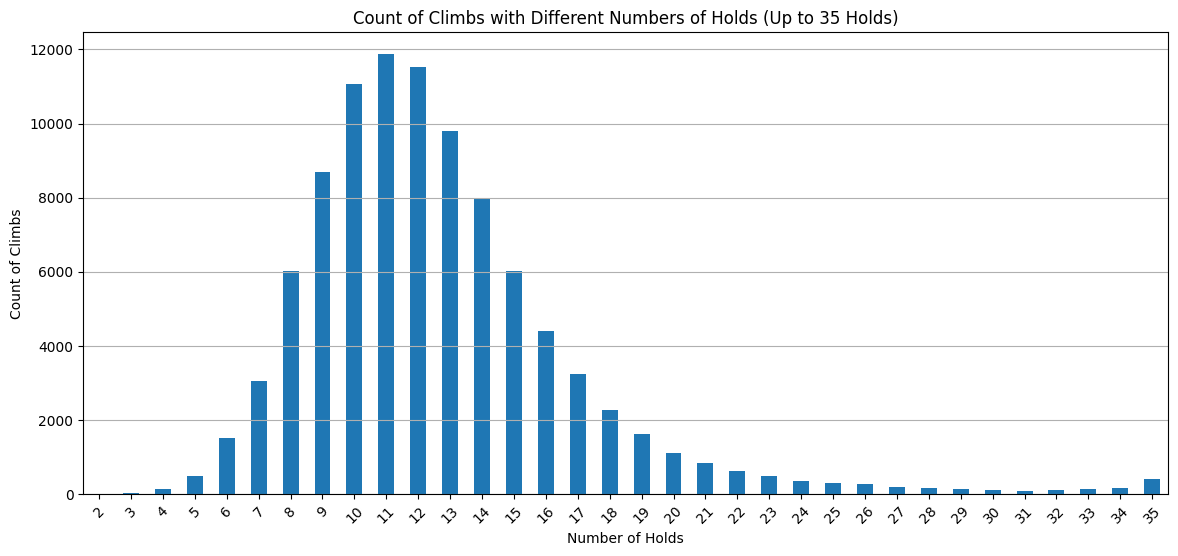

Average Number of Holds: 12.626936592017621


In [8]:
# Calculate vgrade counts
vgrade_counts = filtered_df['vgrade'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
bars = vgrade_counts.plot(kind='bar', color='skyblue')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', ha='center', va='bottom')
plt.title('Count of Climbs for Each vgrade')
plt.xlabel('vgrade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Assuming 'filtered_df' contains your DataFrame with the 'frames' column
filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

# Filter out counts beyond 35 holds
filtered_counts = filtered_df['hold_count'].value_counts().sort_index().loc[:35]

# Plotting the count of climbs with a certain number of holds
plt.figure(figsize=(14, 6))  # Adjust the width by changing the first value (e.g., 14)
filtered_counts.plot(kind='bar')
plt.title('Count of Climbs with Different Numbers of Holds (Up to 35 Holds)')
plt.xlabel('Number of Holds')
plt.ylabel('Count of Climbs')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

total_hold_count = (filtered_counts.index * filtered_counts).sum()

# Calculate total count of climbs
total_climbs = filtered_counts.sum()

# Calculate average number of holds
average_holds = total_hold_count / total_climbs

print("Average Number of Holds:", average_holds)

### Preprocessing Data Functions

In [9]:
def id_to_index(id):
    
    if id <=1089: #bottom large (row) 17x1
        index_offset = 35
        row_index = 16 - (id - 1074)
        final_index = index_offset + 2 * row_index
    elif id <= 1395: #big holds (matrix) 17x18
        index_offset = 35 + 35
        index = id-1089
        row = index//17
        row_index = index%17
        final_index = index_offset + row * 70 + 2 *row_index   
    elif id <=1464: #bottom small (row) 18x1
        row_index = 17 - (id - 1447)
        final_index = 2 * row_index + 1
    elif id <= 1599: # small holds (matrix) 9x15
        index_offset = 35 + 35 + 35 + 1
        index = id-1464
        row = index//9
        row_index = index% 9
        final_index = index_offset + row * 70 + 4 * (row_index-1)
    else:
        final_index = id
        print(id) 
    return final_index

def id_to_coordinate(id):
    index = id_to_index(id)-1
    x = index % 35
    y = index//35
    if y >=35:
        y-=2 #because the top 2 rows of large hand holds dont have any feet so its offset
    return (x,y)

# ids = [1464,1447,1088,1089,1090,1107,1109, 1465]
# for id in range(len(ids)):
#     print(f"position {id+1}({ids[id]}): {id_to_index(ids[id])} {id_to_coordinate(ids[id])}")

# the value is:
# 2-feet 
# 3-start 
# 4-hand 
# 5-finish
def frame_to_ids(frame):
    ids_list_1 = []
    ids_list_2 = []
    
    # Split the frame string based on the 'p' delimiter
    filtered_frame = frame.replace(',', '').replace('"', '')
    frame_parts = filtered_frame.split('p')[1:]
    
    for entry in frame_parts:
        parts = entry.split('r')
        id_1 = int(parts[0])
        id_2 = int(parts[1])
        
        ids_list_1.append(id_1)
        if id_2 in [12, 13, 14, 15]:
            id_2 = [2, 3, 4, 5][id_2 - 12]
        ids_list_2.append(id_2)
    return ids_list_1, ids_list_2

# takes in frame and converts to list of triplets with xy being coordiante in board matrix and z being the value
def frame_to_triplets(frame):
    ids_list_1, ids_list_2 = frame_to_ids(frame)
    
    triplet_list = []
    for id_1, id_2 in zip(ids_list_1, ids_list_2):
        coordinate = id_to_coordinate(id_1)
        triplet = (coordinate[0], coordinate[1], id_2)
        triplet_list.append(triplet)
    
    return triplet_list

frame = "p1127r12p1164r12p1233r13p1235r13p1283r13p1287r13p1299r13p1348r13p1379r14p1458r15p1507r15"
triplet_list = frame_to_triplets(frame)
print("Triplet List:", triplet_list)

def triplets_to_matrix(triplet_list):
    # Initialize a 35x35 matrix with zeros
    matrix = [[0] * 35 for _ in range(35)]
    
    # Populate the matrix with z-values from the triplets
    for triplet in triplet_list:
        x, y, z = triplet
        matrix[34-y][x] = z
    
    return matrix

# matrix = triplets_to_matrix(triplet_list)
# for row in matrix:
#     print(row)

def frame_to_sparse_matrix(frame):
    triplet_list = frame_to_triplets(frame)
    matrix = triplets_to_matrix(triplet_list)
    sparse_matrix = sp.coo_matrix(matrix)
    return sparse_matrix

def is_frame_valid(frame):
    # Extract the first list of IDs from the frame
    if "x" in frame:
        return False
    ids_list_1, _ = frame_to_ids(frame)
    
    # look if any value in the first list is greater than 2000
    for value in ids_list_1:
        if value > 2000:
            return False
    return True

Triplet List: [(7, 6, 2), (13, 10, 2), (15, 18, 3), (19, 18, 3), (13, 24, 3), (21, 24, 3), (11, 26, 3), (7, 32, 3), (1, 34, 4), (12, 0, 5), (24, 11, 5)]


### Create Training and Testing Sets from DF 
* preprocess the data
* convert to coo sparse matrix representations
* load into 2 pkl files

In [10]:
import pickle
import random
from sklearn.model_selection import train_test_split

# Initialize an empty dictionary to store sparse matrices
sparse_matrix_dict = {}
total_climbs = len(filtered_df)
climbs_to_process = 100 # 94635  

# shuffle the indices of climbs in the DataFrame
climb_indices = list(range(total_climbs))
random.shuffle(climb_indices)
climbs_processed = 0

# iterate over randomly selected climbs, convert each frame to sparse matrix, and store it in the dictionary
for idx in climb_indices:
    if climbs_processed >= climbs_to_process:
        break  # Exit the loop if the desired number of climbs processed is reached
    
    climb_frame = filtered_df.iloc[idx]['frames']
    if is_frame_valid(climb_frame):
        sparse_matrix = frame_to_sparse_matrix(climb_frame)
        sparse_matrix_dict[f'climb_{idx}'] = sparse_matrix
        
        climbs_processed += 1
# print(climbs_processed)

# create dataset
with open('sparse_matrices.pkl', 'wb') as f:
    pickle.dump(sparse_matrix_dict, f)
with open('sparse_matrices.pkl', 'rb') as f:
    sparse_matrix_dict = pickle.load(f)

#split dataset into training and test
train_matrices, test_matrices = train_test_split(list(sparse_matrix_dict.values()), test_size=0.2, random_state=42)
with open('training_set.pkl', 'wb') as f:
    pickle.dump(train_matrices, f)
with open('testing_set.pkl', 'wb') as f:
    pickle.dump(test_matrices, f)


### VAE Model

In [11]:
# %pip install numpy
# %pip install tqdm
# %pip install torchvision
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip list
# print(torch.cuda.is_available())

In [12]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

### Model Hyperparameters

In [13]:
dataset_path = '~/datasets'

cuda = False # set True or False if using cuda
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 35 #35x35
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 10

### Custom Dataset and Dataloader

In [14]:
from torch.utils.data import Dataset, DataLoader

class CustomSparseMatrixDataset(Dataset):
    def __init__(self, file_path, train=True):
        self.train = train
        # oad train or test data 
        if self.train:
            self.data = self.load_sparse_matrices(file_path_train)
        else:
            self.data = self.load_sparse_matrices(file_path_test)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # takes in index of COO sparse matrix and converts to a PyTorch sparse coo tensor
        sparse_matrix = self.data[idx]
        indices = torch.LongTensor(np.vstack([sparse_matrix.row, sparse_matrix.col]))
        values = torch.FloatTensor(sparse_matrix.data)
        shape = torch.Size(sparse_matrix.shape)
        sparse_tensor = torch.sparse_coo_tensor(indices, values, shape)
        return sparse_tensor

    def load_sparse_matrices(self, file_path):
        with open(file_path, 'rb') as f:
            sparse_matrices = pickle.load(f)
        return sparse_matrices
    
def custom_collate_fn(batch):
    # takes in batch/list of sparse tensors and converts to tuple of sparse tensors
    return tuple(batch)

file_path_train = "training_set.pkl"
file_path_test = "testing_set.pkl"

# Create train and test datasets
train_dataset = CustomSparseMatrixDataset(file_path_train, train=True)
test_dataset = CustomSparseMatrixDataset(file_path_test, train=False)

print(f"First item in the test dataset:{train_dataset[43]}")
# DataLoader params
batch_size = 64
kwargs = {'num_workers': 0, 'pin_memory': False, 'collate_fn': custom_collate_fn}

# train and test DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

First item in the test dataset:tensor(indices=tensor([[ 0,  2,  8, 12, 13, 15, 16, 18, 19, 26, 27, 28, 32, 34],
                       [11,  1,  9,  9, 12, 12,  5, 15,  0, 15,  8,  7, 13, 18]]),
       values=tensor([4., 3., 3., 3., 5., 5., 3., 3., 5., 3., 5., 2., 2., 5.]),
       size=(35, 35), nnz=14, layout=torch.sparse_coo)


### Encoder, Decoder, and Model

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [16]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Loss Function and Optimizer

In [17]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    x_dense = torch.sigmoid(x.to_dense())
    # Normalize the input values to be between 0 and 1
    x_hat_normalized = torch.sigmoid(x_hat)
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x_dense, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Training VAE

In [20]:
print("Start training VAE...")
model.train()
# for every batch index and batch data samples(x) loaded by the train loader
# x uses collate function to represent tuple of sparse tensors
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x[0].view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


NotImplementedError: Could not run 'aten::view' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::view' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, MkldnnCPU, NestedTensorCPU, NestedTensorCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at aten\src\ATen\RegisterCPU.cpp:31357 [kernel]
CUDA: registered at aten\src\ATen\RegisterCUDA.cpp:44411 [kernel]
Meta: registered at aten\src\ATen\RegisterMeta.cpp:26984 [kernel]
QuantizedCPU: registered at aten\src\ATen\RegisterQuantizedCPU.cpp:944 [kernel]
QuantizedCUDA: registered at aten\src\ATen\RegisterQuantizedCUDA.cpp:459 [kernel]
MkldnnCPU: registered at aten\src\ATen\RegisterMkldnnCPU.cpp:515 [kernel]
NestedTensorCPU: registered at aten\src\ATen\RegisterNestedTensorCPU.cpp:775 [kernel]
NestedTensorCUDA: registered at aten\src\ATen\RegisterNestedTensorCUDA.cpp:931 [kernel]
BackendSelect: fallthrough registered at ..\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at aten\src\ATen\RegisterFunctionalization_3.cpp:24643 [kernel]
Named: registered at ..\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: fallthrough registered at ..\aten\src\ATen\ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at ..\aten\src\ATen\native\NegateFallback.cpp:23 [kernel]
ZeroTensor: registered at aten\src\ATen\RegisterZeroTensor.cpp:161 [kernel]
ADInplaceOrView: registered at ..\torch\csrc\autograd\generated\ADInplaceOrViewType_1.cpp:5216 [kernel]
AutogradOther: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradCPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradCUDA: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradHIP: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradXLA: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradMPS: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradIPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradXPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradHPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradVE: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradLazy: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradMTIA: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradPrivateUse1: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradPrivateUse2: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradPrivateUse3: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradMeta: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradNestedTensor: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18719 [kernel]
Tracer: registered at ..\torch\csrc\autograd\generated\TraceType_3.cpp:14672 [kernel]
AutocastCPU: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at ..\aten\src\ATen\functorch\BatchRulesViews.cpp:558 [kernel]
BatchedNestedTensor: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ..\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ..\aten\src\ATen\LegacyBatchingRegistrations.cpp:1079 [kernel]
VmapMode: fallthrough registered at ..\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ..\aten\src\ATen\functorch\TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:158 [backend fallback]


### Generating with VAE

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:02<?, ?it/s]


In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 35, 35)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

Define Loss function and optimizer

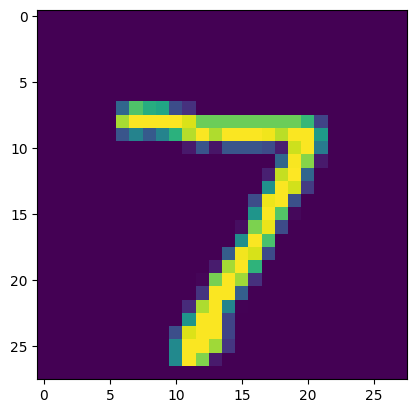

In [ ]:
show_image(x, idx=0)
# def show_climb(x,idx):